In [12]:
import sys
import os
import cartopy.crs as ccrs
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib import rcParams, cycler
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
import numpy as np
import xarray as xr
import geopandas as gpd
import rioxarray
from xeofs.xarray import EOF
import gc
import collections
import statsmodels.api as sm
import scipy
from sklearn.metrics import mean_squared_error
from math import sqrt
from itertools import product
import pyproj
from shapely.geometry import mapping
from xarrayutils.utils import linear_trend, xr_linregress
import pandas as pd

In [2]:
# Define local plotting parameters
sns.set_theme(style="whitegrid")
#sns.set_theme(style="ticks")
sns.set(rc={"figure.dpi":300, 'savefig.dpi':300})
plt.rcParams.update({'font.size': 25})
plt.rc('font', family='sans-serif') 
plt.rc('font', serif='Helvetica Neue')

## Define directories

In [3]:
# Define project repo path
inDirName = '/Users/smurugan9/research/aislens/aislens_emulation/'

# DATA FILE PATHS

# Data containing regridded flux and SSH for 150 years
regriddedFluxSSH_filepath = 'data/interim/RegriddedFluxSSH.nc'

# File contains all defined ice shelves
iceShelvesShape_filepath = 'data/interim/iceShelves.geojson'

# Folder for output figures
figures_folderpath = 'reports/figures/' 

interim_data_folder = 'data/interim/'
flux_dedrafted_data_path = 'dedrafted_flux_IMBIE/'
randomized_realizations_path = 'randomized_realizations/'
flux_dedrafted_iceshelves_data_path = 'iceshelves_dedrafted_flux/'
reconstructions_neofs_path = 'reconstructions_neofs/'
cise_file_path = 'cise_data/'

In [4]:
# Read geoJSON region feature file as GeoDataFrame
iceshelvesmask = gpd.read_file(inDirName + iceShelvesShape_filepath)
# Convert to south polar stereographic projection
icems = iceshelvesmask.to_crs({'init': 'epsg:3031'});
crs = ccrs.SouthPolarStereo();

/Users/smurugan9/opt/anaconda3/envs/aislens/lib/python3.10/site-packages/pyproj/crs/crs.py:131: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


## Input Data Files

In [5]:
# Original forcing data: raw MPAS-O output, mapped to the 10km resolution grid
regridded_data = xr.open_dataset(inDirName+regriddedFluxSSH_filepath)
flux = regridded_data.timeMonthly_avg_landIceFreshwaterFlux
ssh = regridded_data.timeMonthly_avg_ssh

# Pre-processed data: detrended, deseasonalized, dedrafted
flux_clean = xr.open_dataset(inDirName+interim_data_folder+'flux_clean')
flux_clean = flux_clean.timeMonthly_avg_landIceFreshwaterFlux

# Flux and ssh datapoints extracted for individual ice shelves, used for the scatter plots
catchments_scatter = np.load(inDirName+interim_data_folder+"catchments_scatter.npy")


# Add reconstructed datasets - seed random

In [6]:
flux_ts = flux.sum(['x','y'])
flux_clean_ts = flux_clean.sum(['x','y'])

In [7]:
# Remove temporal mean
flux_demeaned = flux - flux.mean('time')
flux_demeaned_ts = flux_demeaned.sum(['x','y'])

In [13]:
%%time
# Dedraft: Linear Regression with SSH - DEDRAFTED FOR INDIVIDUAL ICE SHELVES
flux_regress = xr_linregress(ssh, flux.mean('time'),dim='time') # h = independent variable
flux_pred = flux_regress.slope*ssh.mean('time') + flux_regress.intercept
flux_dedraft = flux - flux_pred

CPU times: user 26.7 s, sys: 55.3 s, total: 1min 21s
Wall time: 1min 58s


In [8]:
# Deseasonalize
# Remove climatologies to isolate anomalies, i.e., internal variability
flux_month = flux_demeaned.groupby("time.month")
flux_clm = flux_month.mean("time") # Climatologies
flux_anm = flux_month - flux_clm # Deseasonalized anomalies

In [9]:
flux_clm_ts = flux_clm.sum(['x','y'])
flux_anm_ts = flux_anm.sum(['x','y'])

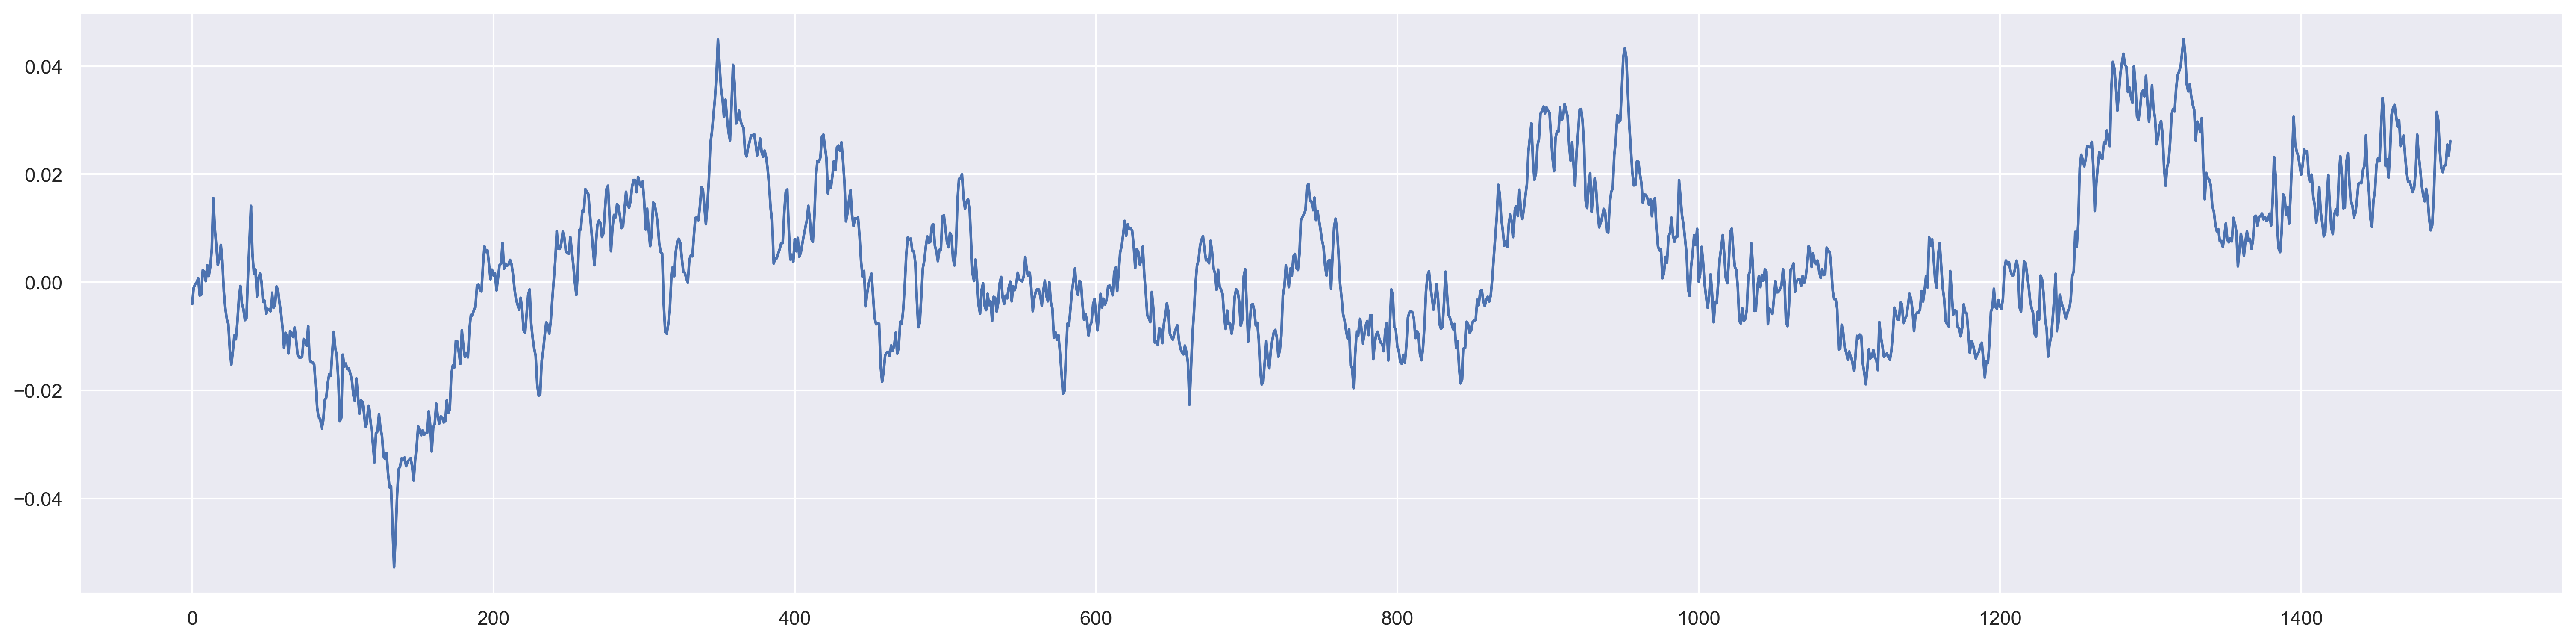

In [11]:
plt.figure(figsize=(25,6))
#plt.plot(flux_ts[300:])

#plt.plot(flux_clean_ts)
#plt.plot(flux_anm_ts[300:])
plt.plot(flux_clean_ts)
#plt.plot(flux_ssnl_ts)